### Load Packages
The Compose package is going to be used for some the charts.

In [1]:
using Alice

In [2]:
using Compose

___
### Motivation
In single layer models (e.g. GLMs like logistic regression) we can initialise all weights to zero. This seems reasonable if the inputs have been normalised and we have no prior information giving an expectation of which weights will be positive and which will be negative. We're also guaranteed to find the loss function global minimum from any initialisation.

For neural networks, however, setting all weights to zero is a mistake. If all weights were initially set to zero the neurons in a hidden layer would all start at the identical value and have the identical gradients - so learning will maintain this symmetry and we won't be able to learn an interesting structure.

To break the symmetry we have to initialise the weights independantly away from zero and ideally we'd like to do this in such a way that the sigmoid activation function is primarily activated in it's linear region. If the absolute value of the weights are too large the sigmoid will saturate resulting in small gradients and slow learning. For deep neural networks this has to be maintained in each layer as the information is propogated forward.

Achieving a good initialisation requires coordination between the training set normalisation, the choice of activation function, and the choice of the distribution from which the initial values of the weights are sampled from.

___
### Sigmoid activation functions
Let's take a look at three sigmoid functions and their gradients.  
`logistic` and `tanh` are defined in the Alice package and additionally we're going to look at a sigmoid from the LeCun paper discussed below.

Note that all the gradients are virtually zero beyond an input value of $5$. The `tanh` gradients saturate quicker but they have a higher gradient value in the linear region which is often stated as the reason why `tanh` is preferable to `logistic`.

The goal is to initialise the network weights so that learning can take place straight away. In the words of the LeCun paper:  
"Intermediate weights that range over the sigmoids linear region have the advantage that (1) the gradients are large enough that learning can proceed, and (2) the network will learn the linear part of the mapping before the more difficult nonlinear part."

In [ ]:
logistic(z) = 1.0 / (1.0 + exp(-z))
lecun_tanh(z) = 1.7159 * tanh(2/3 * z);

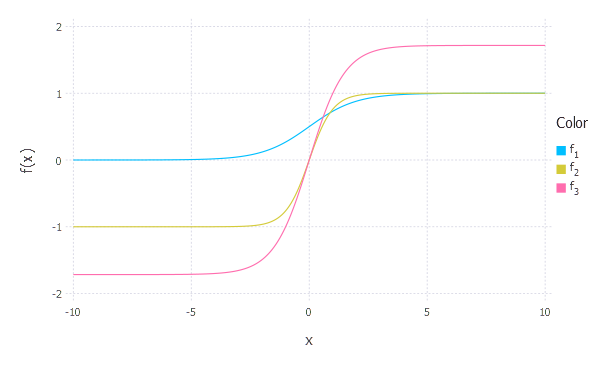

In [6]:
set_default_plot_size(16cm, 16cm/golden)
plot([logistic, tanh, lecun_tanh], -10, 10)

In [7]:
logistic_grad(z) = logistic(z) * (1 - logistic(z))
tanh_grad(z) = 1 - tanh(z)^2
lecun_tanh_grad(z) = 1.7159 * 2/3 * (1 - tanh(z)^2);

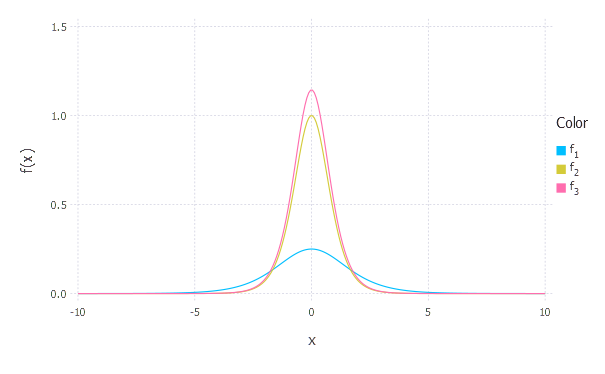

In [8]:
plot([logistic_grad, tanh_grad, lecun_tanh_grad], -10, 10)

___

## 1. Le Cun Initialisation
The advice from [this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) (Le Cun, Bottou, Orr and Müller - 1998) is to scale the variance of the weight distribution by the inverse of the fan_in (the number of incoming features).

___
#### Setup / Notation
For a given neuron in layer $2$ the inputs to the activation function are  
(where $n$ is the number of incoming features):  
$$z = \sum_{i=1}^{n} w_i x_i$$

Note that the bias can be ignored as that will be initialised to $0$. Symmetry is completely broken by initialising the $w_i$'s away from $0$.

___
#### Expected Value and Variance of z
Assuming that the initial values have been normalised to a standard normal i.e. $x_i \sim \mathcal{N}(0, 1)$ and the weights are drawn (independantly) from a symmetrical distribution with mean $0$. I.e.
$$\operatorname{E}[x_i] = 0, \ \operatorname{Var}[x_i] = 1, \ \operatorname{E}[w_i] = 0, \ \text{and} \ x_i \perp w_i $$

The expected value of $z$ is
$$\operatorname{E}[z] = \sum_{i=1}^{n} \operatorname{E}[w_i x_i] = \sum_{i=1}^{n} \operatorname{E}[w_i] \operatorname{E}[x_i] = 0$$ 

And the variance of $z$ is
$$\operatorname{Var}[z] = \sum_{i=1}^{n} \operatorname{Var}[x_i w_i] = \sum_{i=1}^{n} (\operatorname{E}[w_i])^2 \operatorname{Var}[x_i] + (\operatorname{E}[x_i])^2 \operatorname{Var}[w_i] + \operatorname{Var}[x_i] \operatorname{Var}[w_i] = \sum_{i=1}^{n} \operatorname{Var}[x_i] \operatorname{Var}[w_i] = \sigma_w^2 n$$ 

Or, to summarise, we have  
$$\sigma_z^2 = \sigma_w^2 n$$

___
#### Variance of the inputs into the activation function
Let's say we want $\sigma_z^2 = 1$. In that case $99.7\%$ of the $z$ values should be in the range $(\mu - 3\sigma, \mu + 3\sigma) = (-3.0, 3.0)$. We'd need to choose $\sigma_w^2 = \frac{1}{n}$ or $\sigma_w = \frac{1}{\sqrt{n}}$ and therefore we could draw $w_i$ from $\, \mathcal{U}\big[-\sqrt{\frac{3}{n}}, \sqrt{\frac{3}{n}}\big] \,$ or $\, \mathcal{N}\big(0, \frac{1}{n}\big)$.  

Or say we want  $\sigma_z^2 = \frac{1}{3}$. In that case $99.7\%$ of the $z$ values should be in the range $(\mu - 3\sigma, \mu + 3\sigma) \approx (-1.732, 1.732)$. We'd need to choose $\sigma_w^2 = \frac{1}{3n}$ or $\sigma_w = \frac{1}{\sqrt{3n}}$ and therefore we could draw $w_i$ from $\, \mathcal{U}[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}] \,$ or $\, \mathcal{N}(0, \frac{1}{3n})$.

The gradients of the `tanh` function saturate quicker than the `logistic` function. So I've seen the  $\sigma_z^2 = 1$ choice used for `logistic` and the $\sigma_z^2 = \frac{1}{3}$ choice used for `tanh`.

___
#### Variance of the outputs of the activation function 
The paper recommends using this activation function:
$$\operatorname{f}(x) = 1.7159 \, \operatorname{tanh}(\frac{2}{3} x)$$

which has a few useful properties - one of which is to keep the variance of the outputs near $1$ given the variance of the inputs is close to $1$.

___
### Simulation
Let's test, by simulation, the distribution of input values into the activation function.

In [9]:
function print_stats(z::Array)
    # Get results
    num_obs = length(z)
    μ, σ, σ² = mean(z), std(z), var(z)
    two_σ, three_σ = [(μ - 2σ) (μ + 2σ)], [(μ - 3σ) (μ + 3σ)]
    two_σ_p = sum((z .> two_σ[1]) & (z .< two_σ[2])) / num_obs
    three_σ_p = sum((z .> three_σ[1]) & (z .< three_σ[2])) / num_obs
    
    # Print them
    @printf("μ = %0.3f\nσ = %0.3f\nσ² = %0.3f\n", μ, σ, σ²)
    @printf("(μ - 2σ, μ + 2σ) = (%0.3f, %0.3f)  |  ", two_σ[1], two_σ[2])
    @printf("Pr(μ - 2σ ≤ z ≤ μ + 2σ) = %0.3f\n", two_σ_p)
    @printf("(μ - 3σ, μ + 3σ) = (%0.3f, %0.3f)  |  ", three_σ[1], three_σ[2])
    @printf("Pr(μ - 3σ ≤ z ≤ μ + 3σ) = %0.3f", three_σ_p)
end;

**`Distribution = Normal(0, sqrt(1/n))`**

In [10]:
n = 100
num_obs = 10000
z = zeros(num_obs)
for i in 1:num_obs
    x = rand(Normal(0, 1), n)
    w = rand(Normal(0, sqrt(1/n)), n)
    z[i] = dot(x, w)
end
print_stats(z)

μ = 0.005
σ = 1.020
σ² = 1.040
(μ - 2σ, μ + 2σ) = (-2.034, 2.044)  |  Pr(μ - 2σ ≤ z ≤ μ + 2σ) = 0.953
(μ - 3σ, μ + 3σ) = (-3.054, 3.064)  |  Pr(μ - 3σ ≤ z ≤ μ + 3σ) = 0.997

**`Distribution = Uniform(-sqrt(3/n), sqrt(3/n))`**

In [11]:
n = 100
num_obs = 10000
z = zeros(num_obs)
for i in 1:num_obs
    x = rand(Normal(0, 1), n)
    w = rand(Uniform(-sqrt(3/n), sqrt(3/n)), n)
    z[i] = dot(x, w)
end
print_stats(z)

μ = -0.003
σ = 1.001
σ² = 1.002
(μ - 2σ, μ + 2σ) = (-2.005, 1.999)  |  Pr(μ - 2σ ≤ z ≤ μ + 2σ) = 0.955
(μ - 3σ, μ + 3σ) = (-3.006, 3.000)  |  Pr(μ - 3σ ≤ z ≤ μ + 3σ) = 0.998

___

## 2. Glorot Initialisation
[This paper](http://www.jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) by Glorot and Bengio provides a way to control the initial variance of the outputs and gradients in all layers in a deep neural network when using the standard logistic or tanh functions.

___
#### Setup / Notation
Let's look at a single neuron in layer $\ell$. For simplicity the $^{(\ell)}$ superscript is not shown for the variables in the layer we are inspecting. But the supercripts denoting the previous layer - $^{(\ell-1)}$ - and the next layer - $^{(\ell+1)}$ - are shown.
- $n_{\ell} \hspace{0.7cm}$ - the number of inputs feeding into the neuron,
- $z \hspace{1.0cm}$ - the input into the activation function,
- $a_i^{(\ell-1)} \hspace{0.12cm}$ - the post activation outputs of the $i^{\text{th}}$ neuron in the previous layer,
- $w_i \hspace{0.75cm}$ - the weight of neuron $a^{(\ell-1)}_i$ contributing to $z$
- $\operatorname{f} \hspace{1.0cm}$ - the activation function, 
- $a \hspace{0.95cm}$ - the post activation outputs of the neuron,
- $\delta \hspace{0.99cm}$ - $\frac{\partial J}{\partial z}$ i.e. the derivative of the cost function with respect to $z$,
- $\delta_i^{(\ell + 1)} \hspace{0.17cm}$ - $\frac{\partial J}{\partial z_i^{(\ell + 1)}}$ i.e. the derivative of the cost function with respect to $z_i^{(\ell + 1)}$,
- $w_i^{(\ell + 1)} \hspace{0.09cm}$ - the weight of neuron $a$ contributing to $z^{(\ell+1)}_i$

We calculate this neurons output during forward propagation with

$$z = \sum_{i=1}^{n_{\ell}} w_i \, a_i^{(\ell - 1)} \hspace{0.8cm} \text{and} \hspace{0.8cm} a = \operatorname{f}(z)$$

And we calculate this neuron's delta and the parameter gradients during back propagation with

$$\delta = \big( \sum_{i=1}^{n_{\ell+1}} \delta_i^{(\ell + 1)} w_i^{(\ell + 1)}\big) \operatorname{f}^\prime(z) \hspace{0.8cm} \text{and} \hspace{0.8cm} \frac{\partial J}{\partial w_i} = \delta \, a_i^{(\ell - 1)}$$

One of the observations in this paper is that, as well as controlling (by scaling the variance of $w$ with the inverse of $n_{\ell}$ / fan_in) the variance of $z$ through the layers so that $\operatorname{f}^\prime(z)$ does not saturate, we also want to prevent the deltas from shrinking or exploding (and therefore the paramater gradients i.e. $\frac{\partial J}{\partial w_i}$ from shrinking or exploding) and to do this we should also scale the variance of $w$ using the inverse of $n_{\ell+1}$ / fan_out. Just as the fan_in has a multiplicative effect on the variance of $z$ the fan_out has a multiplicative effect on the variance of $\delta$.

___
#### Variance of the outputs - $a$
Following the LeCun derivation above, and assuming the same about normalisation of inputs, we have

$$\sigma_z^2 = \sigma_w^2 \, n_{\ell}$$

We'd like a formula for $\sigma_a^2$ but this isn't linear. For the sigmoid functions the variance of $a$ as a function of the variance of $z$ is a non-linear concave function that increases from $0$ to a plateau value (different for each sigmoid). But we can estimate this function using a first order (linear) approximation (centered at the expected value i.e. zero) which is

$$\sigma_a^2 = (\operatorname{f}^\prime (\operatorname{E}[z]))^2 \, \sigma_z^2 = (\operatorname{f}^\prime (\operatorname{E}[z]))^2 \, n_{\ell} \, \sigma_w^2$$

___
#### Variance of the delta - $\delta$
Assuming we we want to keep $\operatorname{Var}[\delta^{(\ell)}] = 1$ in each layer i.e. in the below we are assuming $\operatorname{Var}[\delta^{(\ell+1)}] = 1$ we can calculate the variance of $\delta$ as follows:

$$\sigma^2_\delta = \big( \sum_{i=1}^{n_{\ell+1}} \operatorname{Var}[\delta_i^{(\ell+1)}] \operatorname{Var}[w_i] \big) \, (\operatorname{f}^\prime (\operatorname{E}[z]))^2 = (\operatorname{f}^\prime (\operatorname{E}[z]))^2 \, n_{\ell+1} \, \sigma_w^2$$

This gives a constraint very similar to the one above.
___
#### Logistic Function
For the logistic function these two formulas are

$$\sigma_a^2 = \frac{n_{\ell}}{16} \, \sigma_w^2 \hspace{0.8cm} \text{and} \hspace{0.8cm} \sigma_\delta^2 = \frac{n_{\ell+1}}{16} \, \sigma_w^2 $$

So, in order to keep $\sigma_a^2 \approx 1$ and $\sigma_\delta^2 \approx 1$ we have these two constraints

$$\sigma_w^2 = \frac{16}{n_{\ell}} \hspace{0.8cm} \text{and} \hspace{0.8cm} \sigma_w^2 = \frac{16}{n_{\ell+1}}$$

The paper recommends, as a compromise, using the average i.e.

$$\sigma_w^2 = \frac{32}{n_{\ell} + n_{\ell+1}} \hspace{0.8cm} \text{or} \hspace{0.8cm} \sigma_w = 4 \frac{\sqrt{2}}{\sqrt{n_{\ell} + n_{\ell+1}}}$$

We could, therefore, draw $w_i$ from 
$$\, \mathcal{U}\big[-4 \frac{\sqrt{6}}{\sqrt{n_{\ell} + n_{\ell+1}}}, 4 \frac{\sqrt{6}}{\sqrt{n_{\ell} + n_{\ell+1}}}\big] \hspace{0.8cm} \text{or} \hspace{0.8cm} \mathcal{N}\big(0, \frac{32}{n_{\ell} + n_{\ell+1}}\big)$$

___
#### Tanh function
For the tanh function, following the same requirements that $\sigma_a^2 \approx 1$ and $\sigma_\delta^2 \approx 1$, we have these two constraints

$$\sigma_w^2 = \frac{1}{n_{\ell}} \hspace{0.8cm} \text{and} \hspace{0.8cm} \sigma_w^2 = \frac{1}{n_{\ell+1}}$$

The compromise constraint is
$$\sigma_w^2 = \frac{2}{n_{\ell} + n_{\ell+1}} \hspace{0.8cm} \text{or} \hspace{0.8cm} \sigma_w = \frac{\sqrt{2}}{\sqrt{n_{\ell} + n_{\ell+1}}}$$

And we could, therefore, draw $w_i$ from 
$$\, \mathcal{U}\big[- \frac{\sqrt{6}}{\sqrt{n_{\ell} + n_{\ell+1}}}, \frac{\sqrt{6}}{\sqrt{n_{\ell} + n_{\ell+1}}}\big] \hspace{0.8cm} \text{or} \hspace{0.8cm} \mathcal{N}\big(0, \frac{2}{n_{\ell} + n_{\ell+1}}\big)$$

### Simulations
Let's observe some of this by observing the densities of a deep(ish) network.

In [12]:
function plot_densities(arrays, names, x_text, minval, maxval)
    
    # Size
    set_default_plot_size(20cm, 10cm)
    
    # Colours
    clrs = [colorant"lightblue", colorant"red", colorant"green", colorant"blue", colorant"black", colorant"orange"]
    cnames = ["lightblue", "red", "green", "blue", "black", "orange"]
    
    # Create plotlayer for each array - density plot
    n = length(arrays)
    plotlayers = []
    for i in 1:n
        push!(plotlayers, layer(x=arrays[i], Geom.density, Theme(default_color=clrs[i])))
    end
    
    # Make a manual color key
    key = Guide.manual_color_key("", names, cnames[1:n])
    mykey = render(key, Theme(colorkey_swatch_shape = :circle), Gadfly.Aesthetics())[1].ctxs[1]
    kctx = compose(context(), (context(0.88w, -0.34h), mykey), 
    (context(0.87w, 0.04h, 0.10w, 0.28h), rectangle(), linewidth(0.25mm), stroke("lightgray"), fill("white")))
    
    # Axis label
    x_lable = Guide.xlabel(x_text)
    
    # Axis scale
    minmax = Coord.cartesian(xmin=minval, xmax=maxval)
    
    # Plot
    return plot(plotlayers..., minmax, x_lable, Guide.annotation(kctx))
end;

#### Test 1 - bad choice number 1 - exploding gradient
$w_i$ drawn from `Normal(0, 0.01)`
Here the distribution is too narrow and the outputs of each layer are pulled closer to zero causing an exploding gradient.

In [13]:
# Data
input_dim = 1000
num_obs = 2000
input = randn(input_dim, num_obs)
databox = Data(input)

# Input Layer
input = InputLayer(databox, num_obs)

# Fully connected hidden layers
h1_fan_out = 500
fc1 = FullyConnectedLayer(size(input), h1_fan_out, init = Normal(0, 0.01), activation = :tanh)
h2_fan_out = 1000
fc2 = FullyConnectedLayer(size(fc1), h2_fan_out, init = Normal(0, 0.01), activation = :tanh)
h3_fan_out = 500
fc3 = FullyConnectedLayer(size(fc2), h3_fan_out, init = Normal(0, 0.01), activation = :tanh)
h4_fan_out = 1000
fc4 = FullyConnectedLayer(size(fc3), h4_fan_out, init = Normal(0, 0.01), activation = :tanh)

# Net
net = NeuralNet(databox, [input, fc1, fc2, fc3, fc4])

Neural Network
Training Data Dimensions - (1000,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (1000,2000)
Layer 2 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 3 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)
Layer 4 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 5 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)


In [14]:
fwd_prop!(net)

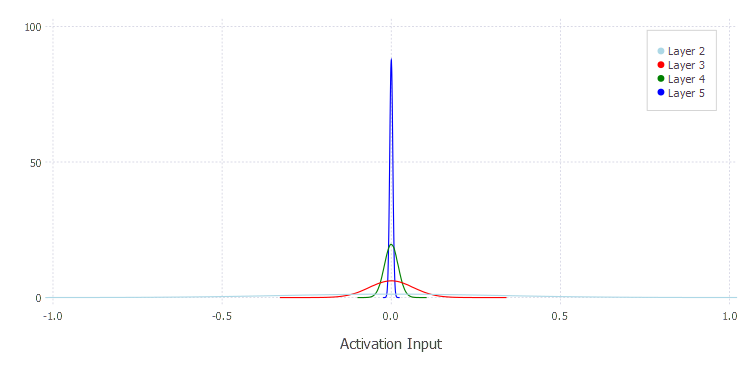

In [15]:
arrays = [fc1.Z, fc2.Z, fc3.Z, fc4.Z]
names = ["Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Input", -1, 1)

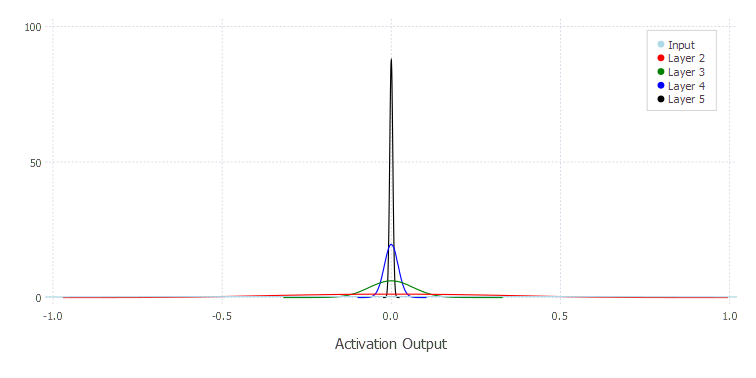

In [16]:
fwd_prop!(net)
arrays = [input.A, fc1.A, fc2.A, fc3.A, fc4.A]
names = ["Input", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Output", -1, 1)

#### Test 2 - bad choice number 2 - vanishing gradient
$w_i$ drawn from `Normal(0, 0.08)` - The distribution is too wide and the outputs of each layer are close to $1$ or $-1$ where gradients are close to zero i.e. causing a vanishing gradient.

In [17]:
# Data
input_dim = 1000
num_obs = 2000
input = randn(input_dim, num_obs)
databox = Data(input)

# Input Layer
input = InputLayer(databox, num_obs)

# Fully connected hidden layers
h1_fan_out = 500
fc1 = FullyConnectedLayer(size(input), h1_fan_out, init = Normal(0, 0.08), activation = :tanh)
h2_fan_out = 1000
fc2 = FullyConnectedLayer(size(fc1), h2_fan_out, init = Normal(0, 0.08), activation = :tanh)
h3_fan_out = 500
fc3 = FullyConnectedLayer(size(fc2), h3_fan_out, init = Normal(0, 0.08), activation = :tanh)
h4_fan_out = 1000
fc4 = FullyConnectedLayer(size(fc3), h4_fan_out, init = Normal(0, 0.08), activation = :tanh)

# Net
net = NeuralNet(databox, [input, fc1, fc2, fc3, fc4])

Neural Network
Training Data Dimensions - (1000,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (1000,2000)
Layer 2 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 3 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)
Layer 4 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 5 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)


In [18]:
fwd_prop!(net)

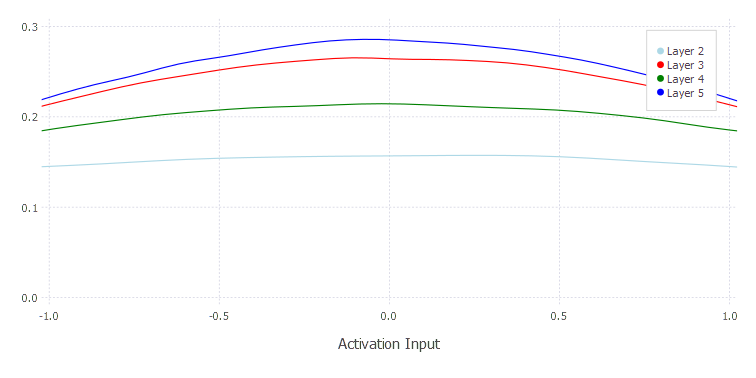

In [19]:
arrays = [fc1.Z, fc2.Z, fc3.Z, fc4.Z]
names = ["Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Input", -1, 1)

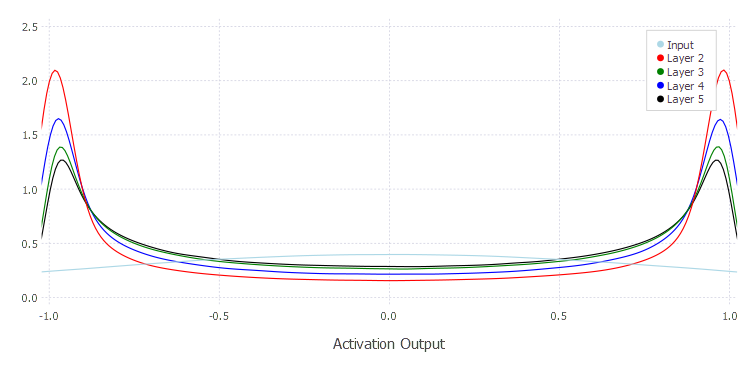

In [20]:
arrays = [input.A, fc1.A, fc2.A, fc3.A, fc4.A]
names = ["Input", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Output", -1, 1)

#### Test 3 - Glorot recommended weights
For this test I've found that initialising the first hidden layer with the LeCun method and subsequent layers with Glorot works well. All hidden layers have outputs in a reasonable range to encourage learning.

In [21]:
# Data
input_dim = 1000
num_obs = 2000
input = randn(input_dim, num_obs)
databox = Data(input)

# Input Layer
input = InputLayer(databox, num_obs)

# Fully connected hidden layers
h1_fan_out = 500
r = sqrt(1 / input_dim)
fc1 = FullyConnectedLayer(size(input), h1_fan_out, init = Uniform(-r, r), activation = :tanh)
h2_fan_out = 1000
fc2 = FullyConnectedLayer(size(fc1), h2_fan_out, init = :glorot_tanh_uniform, activation = :tanh)
h3_fan_out = 500
fc3 = FullyConnectedLayer(size(fc2), h3_fan_out, init = :glorot_tanh_uniform, activation = :tanh)
h4_fan_out = 1000
fc4 = FullyConnectedLayer(size(fc3), h4_fan_out, init = :glorot_tanh_uniform, activation = :tanh)

# Net
net = NeuralNet(databox, [input, fc1, fc2, fc3, fc4])

Neural Network
Training Data Dimensions - (1000,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (1000,2000)
Layer 2 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 3 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)
Layer 4 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (500,2000)
Layer 5 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.tanh, Dimensions - (1000,2000)


In [22]:
fwd_prop!(net)

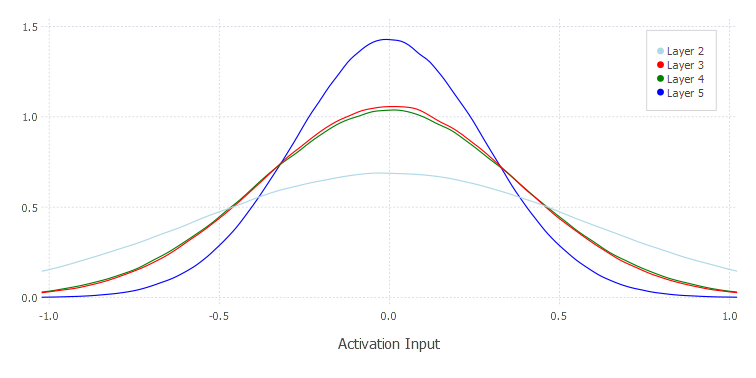

In [23]:
arrays = [fc1.Z, fc2.Z, fc3.Z, fc4.Z]
names = ["Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Input", -1, 1)

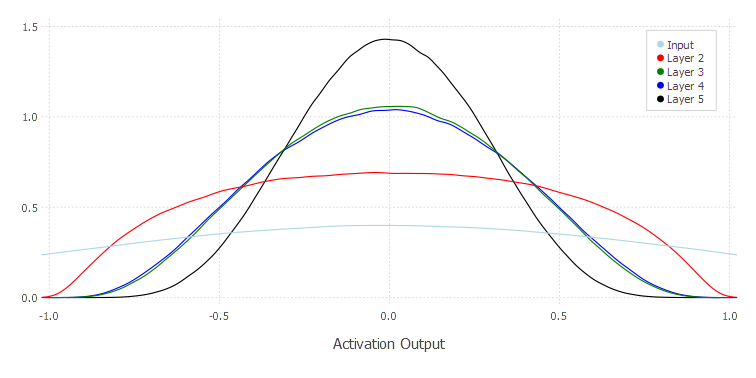

In [24]:
arrays = [input.A, fc1.A, fc2.A, fc3.A, fc4.A]
names = ["Input", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Output", -1, 1)

## 2. He Initialisation
[This paper](http://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) by He, Zhang, Ren and Sun gives recommendations for when using a rectified linear activation function. Some assumptions made above do not apply to the relu function - in particular the relu function is not symmetric about $0$.

___
#### Recommendation
The recommendation given is to scale the variance of $w_i$ with $\frac{2}{n}$ instead of $\frac{1}{n}$ as above. The intuition is that the relu output is zero for half of it's inputs (assuming the inputs $z$ are symmetric and centered at zero) so you need to double the weight varinace to keep the output variance constant.

So the recommendation is to draw $w_i$ from 
$$\, \mathcal{U}\big[- \frac{\sqrt{6}}{\sqrt{n_{\ell}}}, \frac{\sqrt{6}}{\sqrt{n_{\ell}}}\big] \hspace{0.8cm} \text{or} \hspace{0.8cm} \mathcal{N}\big(0, \frac{2}{n_{\ell}}\big)$$

In [25]:
# Data
input_dim = 1000
num_obs = 2000
input = randn(input_dim, num_obs)
databox = Data(input)

# Input Layer
input = InputLayer(databox, num_obs)

# Fully connected hidden layers
h1_fan_out = 500
fc1 = FullyConnectedLayer(size(input), h1_fan_out, init = :he_uniform, activation = :relu)
h2_fan_out = 1000
fc2 = FullyConnectedLayer(size(fc1), h2_fan_out, init = :he_uniform, activation = :relu)
h3_fan_out = 500
fc3 = FullyConnectedLayer(size(fc2), h3_fan_out, init = :he_uniform, activation = :relu)
h4_fan_out = 1000
fc4 = FullyConnectedLayer(size(fc3), h4_fan_out, init = :he_uniform, activation = :relu)

# Net
net = NeuralNet(databox, [input, fc1, fc2, fc3, fc4])

Neural Network
Training Data Dimensions - (1000,2000)
Layers:
Layer 1 - Alice.InputLayer{Float64}, Dimensions - (1000,2000)
Layer 2 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.relu, Dimensions - (500,2000)
Layer 3 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.relu, Dimensions - (1000,2000)
Layer 4 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.relu, Dimensions - (500,2000)
Layer 5 - Alice.FullyConnectedLayer{Float64}, Activation - Alice.relu, Dimensions - (1000,2000)


In [26]:
fwd_prop!(net)

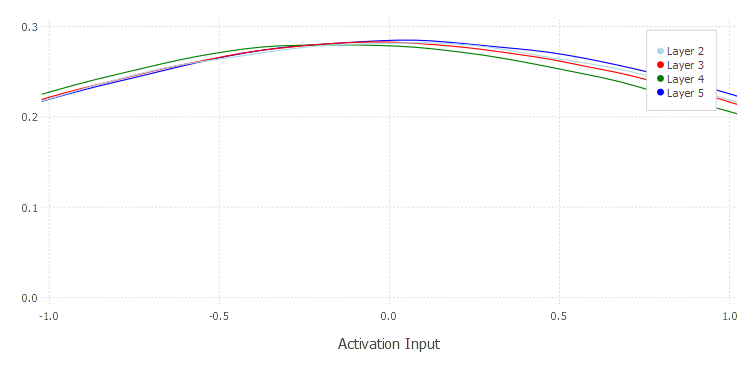

In [27]:
arrays = [fc1.Z, fc2.Z, fc3.Z, fc4.Z]
names = ["Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Input", -1, 1)

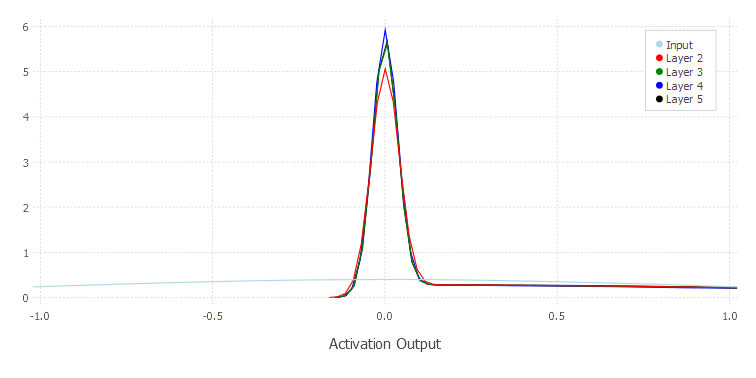

In [28]:
arrays = [input.A, fc1.A, fc2.A, fc3.A, fc4.A]
names = ["Input", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
plot_densities(arrays, names, "Activation Output", -1, 1)